**PPO** **Implementation**

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym

In [18]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

In [19]:
SEED = 1234
train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [20]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [21]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

In [22]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [23]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [24]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (critic): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
LEARNING_RATE = 0.01

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [26]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [27]:
def calculate_advantages(returns, values, normalize = True):
    
    advantages = returns - values
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [28]:
def update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip):
    
    total_policy_loss = 0 
    total_value_loss = 0
    
    advantages = advantages.detach()
    log_prob_actions = log_prob_actions.detach()
    actions = actions.detach()
    
    for _ in range(ppo_steps):
                
        #get new log prob of actions for all input states
        action_pred, value_pred = policy(states)
        value_pred = value_pred.squeeze(-1)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        
        #new log prob using old actions
        new_log_prob_actions = dist.log_prob(actions)
        
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
                
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).sum()
        
        value_loss = F.smooth_l1_loss(returns, value_pred).sum()
    
        optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        optimizer.step()
    
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()
    
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [29]:
def evaluate(env, policy):
    
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
        
            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)
                
        action = torch.argmax(action_prob, dim = -1)
                
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [30]:
def train(env, policy, optimizer, discount_factor, ppo_steps, ppo_clip):
        
    policy.train()
        
    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        #append state here, not after we get the next state from env.step()
        states.append(state)
        
        action_pred, value_pred = policy(state)
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)
        
        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        
        episode_reward += reward
            
    states = torch.cat(states)
    actions = torch.cat(actions)    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip)

    return policy_loss, value_loss, episode_reward

In [31]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10
PPO_STEPS = 5
PPO_CLIP = 0.2

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

| Episode:  10 | Mean Train Rewards:  54.6 | Mean Test Rewards:  82.7 |
| Episode:  20 | Mean Train Rewards:  85.7 | Mean Test Rewards: 231.6 |
| Episode:  30 | Mean Train Rewards: 181.5 | Mean Test Rewards: 348.2 |
| Episode:  40 | Mean Train Rewards: 268.3 | Mean Test Rewards: 361.4 |
| Episode:  50 | Mean Train Rewards: 278.6 | Mean Test Rewards: 340.3 |
| Episode:  60 | Mean Train Rewards: 342.2 | Mean Test Rewards: 382.6 |
| Episode:  70 | Mean Train Rewards: 435.2 | Mean Test Rewards: 449.2 |
| Episode:  80 | Mean Train Rewards: 467.4 | Mean Test Rewards: 485.8 |
Reached reward threshold in 80 episodes


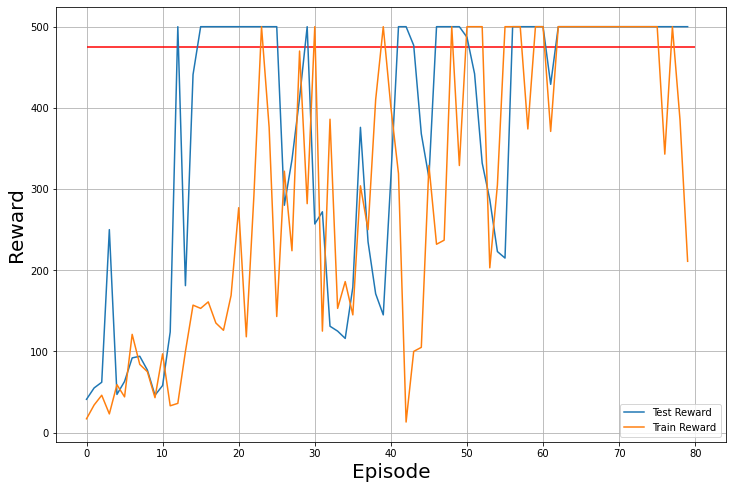

In [16]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()

**DQN**

In [1]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 5.8 MB/s 


In [2]:
%matplotlib inline

In [3]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v1', new_step_api=True, render_mode='single_rgb_array').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


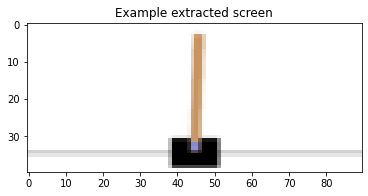

In [6]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [7]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
       # display.clear_output(wait=True)
        display.display(plt.gcf())

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [9]:
num_episodes = 500
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
   
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Evaluation** 


> After reading about DQN and PPO from various resources and seeing the results above, I can safely say that PPO performs better than DQN on Cartpole example. It is because PPO gives consistent results and can reach maximum reward in less number of episodes. For instance, if you look at the DQN implementation above, it is not giving consistent results even after reaching 100 episodes. Therefore, DQN has a higher training time compared to PPO. It is important to note that PPO can sometimes perform worse in the initial phases. Howvever, after sometime, the results become consistent. Hence, for a Cartpole environment, PPO is a better algorithm as it can save time and has stable outcome. 

NOTE: I ran both PPO and DQN for 500 episodes to compare.
NOTE: The output for DQN has multiple outputs because I wanted to see the progression of algorithm. However, the code that you provided only displayed it for a few seconds, which isn't enough to analyze it. 

